In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from pyjet import cluster,DTYPE_PTEPM
import pandas as pd

In [2]:
f = pd.read_hdf('../h5files/events_anomalydetection.h5', stop=10000) #read only first 'stop' events

In [3]:
events_combined = f.T

In [4]:
np.shape(events_combined)


(2101, 10000)

In [131]:
#Now, let's cluster some jets more efficiently!
all_largeRjets = {}
all_smallRjets = {}
all_hadrons = {}
for mytype in ['background','signal']:
    all_largeRjets[mytype]=[]
    all_smallRjets[mytype]=[]
    all_hadrons[mytype]=[]
    
    for ievt in range(2): #len(events_combined)):
        if ievt%10000==0:
            print(mytype,ievt)
        issignal = events_combined[ievt][2100]
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
            continue
        pseudojets_input = np.zeros(len([x for x in events_combined[ievt][::3] if x > 0]), dtype=DTYPE_PTEPM)
        events_filled = events_combined[ievt][:np.shape(pseudojets_input)[0]*3].values.reshape(np.shape(pseudojets_input)[0], 3)

        pseudojets_input['pT'] = events_filled[:, 0]
        pseudojets_input['eta'] = events_filled[:, 1]
        pseudojets_input['phi'] = events_filled[:, 2]
        print(np.shape(events_filled))
        largeR = cluster(pseudojets_input, R=1.0, p=-1)
        largeRjets = largeR.inclusive_jets(ptmin=20)
        print(len(largeRjets))
        smallR = cluster(pseudojets_input, R=0.4, p=-1)
        smallRjets = smallR.inclusive_jets(ptmin=20)

        all_largeRjets[mytype] += [largeRjets]
        all_smallRjets[mytype] += [smallRjets]
        all_hadrons[mytype] += [pseudojets_input]



background 0
(109, 3)
2
(208, 3)
3
signal 0


In [128]:
def getJet(alljets, index):
    jet = {}
    for mytype in ['background','signal']:
        jet[mytype]={'pt':[], 'eta':[], 'phi':[]}
        for ievt in range(len(all_largeRjets[mytype])):
            jet[mytype]['pt'] += [alljets[mytype][ievt][index].pt]
            jet[mytype]['eta'] += [alljets[mytype][ievt][index].eta]
            jet[mytype]['phi'] += [alljets[mytype][ievt][index].phi]
    return jet

# lead_largeRjets, sublead_largeRjets = getJet(all_largeRjets, 0), getJet(all_largeRjets, 1)
lead_smallRjets, sublead_smallRjets = getJet(all_smallRjets, 0), getJet(all_smallRjets, 1)
# print(lead_largeRjets)
# print(sublead_largeRjets)
# print(lead_smallRjets)
# print(sublead_smallRjets)


In [129]:
print(all_largeRjets['background'][1])

[PseudoJet(pt=1356.243, eta=0.825, phi=1.364, mass=624.791), PseudoJet(pt=1335.325, eta=-0.880, phi=-1.773, mass=536.158)]


[PseudoJet(pt=1356.243, eta=0.825, phi=1.364, mass=624.791), PseudoJet(pt=1335.325, eta=-0.880, phi=-1.773, mass=536.158)]
0 88
1 107


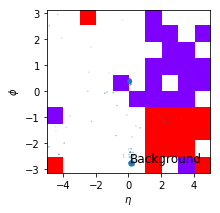

In [130]:
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap

def plot_jet_area(alljets = all_largeRjets, mytype = 'background', ievt = 0):
    # pick a different color for each jet
    eta_min, eta_max = -5., 5.
    extent = eta_min, eta_max, -np.pi, np.pi
    fig = plt.figure(figsize=(9, 3))
    colors = cm.rainbow(np.linspace(0, 1, len(alljets[mytype][ievt])))
    cmap = LinearSegmentedColormap.from_list('cmap', colors, len(colors))
    ax = None
    ax = fig.add_subplot(1, 2, 1, sharey=ax)
    area = np.zeros((10,10), dtype=np.float64)

    print(alljets[mytype][ievt])
    for ijet, jet in enumerate(alljets[mytype][ievt]):
        constit = jet.constituents_array()
        print(ijet, len(constit))
        jetarea, _, _ = np.histogram2d(constit['eta'], constit['phi'],
                                       )
        area += (jetarea > 0) * (ijet + 1)

    # plot all areas
    ax.imshow(np.ma.masked_where(area == 0, area).T, cmap=cmap,
              extent=extent, aspect=(eta_max - eta_min) / (2*np.pi),
              interpolation='none', origin='lower')

    # overlay original event
    particles = all_hadrons['background'][0]
    ax.scatter(particles['eta'], particles['phi'],
               s=30 * particles['pT'] / particles['pT'].max())
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    ax.set_ylabel(r'$\phi$')
    ax.set_xlabel(r'$\eta$')

    ax.text(0.95, 0.05, 'Background',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        fontsize=12)
    
plot_jet_area(alljets = all_largeRjets, mytype = 'background', ievt = 1)

208


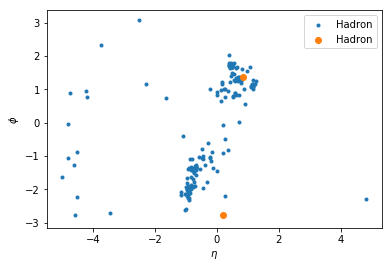

In [54]:
#Let's make some very simple plots.
def plothadron():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    n,b,p = plt.hist(pseudojets_input['eta'], bins=50, facecolor='r', alpha=0.2,label='background')
    plt.xlabel(r'$\eta$')
    plt.ylabel('Number of hadrons')
    plt.legend(loc='upper right')

def plothadron2d():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
#     plt.hist2d(x=pseudojets_input['eta'], y=pseudojets_input['phi'], bins=50, facecolor='r', label='background')
    plt.scatter(x=pseudojets_input['eta'], y=pseudojets_input['phi'], marker='.', label='Hadron')
    plt.scatter(x=lead_largeRjets['background']['eta'], y=lead_largeRjets['background']['phi'], marker='o', label='Hadron')
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$\phi$')
    plt.legend(loc='upper right')
    
plothadron2d()
print(len(pseudojets_input))

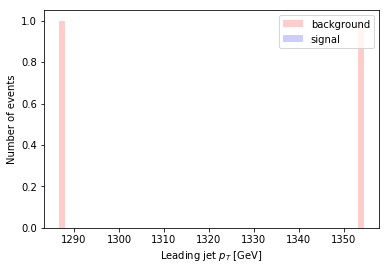

In [26]:
#Let's make some very simple plots.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT_largeRjets['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(leadpT_largeRjets['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'Leading jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("leadjetpt.pdf")

In [12]:
mjj={}
for mytype in ['background','signal']:
    mjj[mytype]=[]
    for k in range(len(all_largeRjets[mytype])):
        E = all_largeRjets[mytype][k][0].e+all_largeRjets[mytype][k][1].e
        px = all_largeRjets[mytype][k][0].px+all_largeRjets[mytype][k][1].px
        py = all_largeRjets[mytype][k][0].py+all_largeRjets[mytype][k][1].py
        pz = all_largeRjets[mytype][k][0].pz+all_largeRjets[mytype][k][1].pz
        mjj[mytype]+=[(E**2-px**2-py**2-pz**2)**0.5]


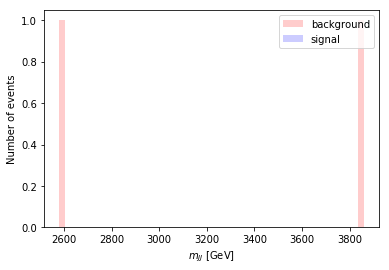

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['background'], bins=50, facecolor='r', alpha=0.2,label='background')
plt.hist(mjj['signal'], bins=b, facecolor='b', alpha=0.2,label='signal')
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.savefig("mjj.pdf")